In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('mpsa')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 6,249
training + validation N: 24,234


,set,tot_ct,ex_ct,y,x
0,training,28,2,-3.273018,GGAGUGAUG
1,training,315,7,-5.303781,AGUGUGCAA
2,validation,27,0,-4.807355,UAAGCUUUU
3,training,130,2,-5.448461,AUGGUCGGG
4,training,552,19,-4.789208,AGGGCAGGA
5,training,151,184,0.283454,AAGGUCCGC
6,training,88,4,-4.153805,CAGGCAAAC
7,training,105,5,-4.142958,GUGGCAAAU
8,validation,14,0,-3.906891,CAUGCAGCU
9,training,170,14,-3.510962,CAAGUCACU


In [3]:
# Get sequence length
L = len(data_df['x'][0])

# Define model
model = mavenn.Model(L=L,
                     alphabet='rna',
                     gpmap_type='pairwise', 
                     regression_type='GE',
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

In [4]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df['y'],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

N = 24,234 observations set as training data.
Using 24.8% for validation.
Data shuffled.
Time to set data: 0.41 sec.


In [5]:
# Fit model to data
model.fit(learning_rate=.001,
          epochs=1000,
          batch_size=50,
          early_stopping=True,
          early_stopping_patience=30,
          linear_initialization=True)

 
LSMR            Least-squares solution of  Ax = b

The matrix A has    18215 rows  and       36 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       36

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.348e+02  4.392e+03   1.0e+00  2.4e-01
     1 -3.59627e-03  1.227e+02  1.570e+03   9.1e-01  1.6e-01  7.8e+01  1.0e+00
     2 -1.68568e-03  1.221e+02  1.266e+03   9.1e-01  7.0e-02  1.5e+02  1.4e+00
     3 -3.03496e-03  1.210e+02  6.590e+01   9.0e-01  2.0e-03  2.7e+02  2.3e+00
     4 -2.44716e-03  1.210e+02  4.345e+00   9.0e-01  1.3e-04  2.8e+02  2.8e+00
     5 -2.52061e-03  1.210e+02  4.571e-01   9.0e-01  1.3e-05  2.9e+02  3.0e+00
     6 -2.52031e-03  1.210e+02  1.664e-02   9.0e-01  4.7e-07  2.9e+02  3.0e+00
 
LSMR finished
The least-squares solution is good enough, given atol     
istop =       2    normr = 1.2e+02
    normA = 2.9e+02    normAr = 1.7e-02
itn

365/365 [==============================] - 1s 3ms/step - loss: 40.1082 - I_var: 0.2858 - val_loss: 39.6483 - val_I_var: 0.2984
Epoch 51/1000
365/365 [==============================] - 1s 3ms/step - loss: 40.0291 - I_var: 0.2882 - val_loss: 39.8168 - val_I_var: 0.2942
Epoch 52/1000
365/365 [==============================] - 1s 3ms/step - loss: 40.0390 - I_var: 0.2889 - val_loss: 39.6339 - val_I_var: 0.3000
Epoch 53/1000
365/365 [==============================] - 1s 2ms/step - loss: 40.0343 - I_var: 0.2906 - val_loss: 40.2467 - val_I_var: 0.2832
Epoch 54/1000
365/365 [==============================] - 1s 3ms/step - loss: 39.9765 - I_var: 0.2924 - val_loss: 39.8341 - val_I_var: 0.2955
Epoch 55/1000
365/365 [==============================] - 1s 3ms/step - loss: 39.8484 - I_var: 0.2988 - val_loss: 39.2416 - val_I_var: 0.3136
Epoch 56/1000
365/365 [==============================] - 1s 2ms/step - loss: 39.8342 - I_var: 0.2986 - val_loss: 39.9471 - val_I_var: 0.2938
Epoch 57/1000
365/365 [====

365/365 [==============================] - 1s 3ms/step - loss: 37.8475 - I_var: 0.3669 - val_loss: 37.6850 - val_I_var: 0.3695
Epoch 108/1000
365/365 [==============================] - 1s 2ms/step - loss: 37.8336 - I_var: 0.3667 - val_loss: 37.4870 - val_I_var: 0.3750
Epoch 109/1000
365/365 [==============================] - 1s 2ms/step - loss: 37.8573 - I_var: 0.3664 - val_loss: 37.3074 - val_I_var: 0.3800
Epoch 110/1000
365/365 [==============================] - 1s 2ms/step - loss: 37.8399 - I_var: 0.3674 - val_loss: 37.6106 - val_I_var: 0.3716
Epoch 111/1000
365/365 [==============================] - 1s 3ms/step - loss: 37.8608 - I_var: 0.3656 - val_loss: 37.3260 - val_I_var: 0.3797
Epoch 112/1000
365/365 [==============================] - 1s 3ms/step - loss: 37.7788 - I_var: 0.3684 - val_loss: 37.8703 - val_I_var: 0.3644
Epoch 113/1000
365/365 [==============================] - 1s 3ms/step - loss: 37.8875 - I_var: 0.3656 - val_loss: 37.6630 - val_I_var: 0.3698
Epoch 114/1000
365/36

In [6]:
# Save model
model.save('mpsa_ge_pairwise')

Model saved to these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [7]:
# Load model
model = mavenn.load('mpsa_ge_pairwise')

Model loaded from these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [8]:
# Get x and y
x_test = test_df['x'].values
y_test = test_df['y'].values

On test data:
I_var_test: 0.340 +- 0.024 bits
I_pred_test: 0.372 +- 0.015 bits


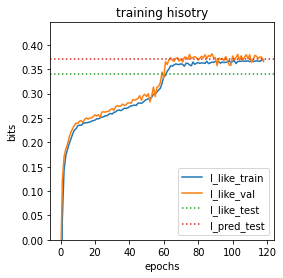

In [9]:
# Show training history
print('On test data:')

# Compute likelihood information
I_var, dI_var =  model.I_varlihood(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);

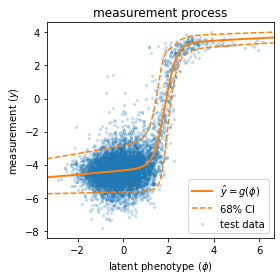

In [10]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

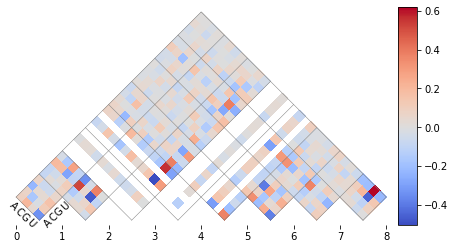

In [11]:
# Plot pairwise parameters
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap_pairwise(values=theta['theta_lclc'],
                        alphabet=theta['alphabet'],
                        ax=ax);

In [12]:
# Test simulate_data
sim_df = model.simulate_dataset(N=1000)
sim_df.head()

,training_set,yhat,phi,y,x
0,True,-4.396646,-0.351826,-4.181143,UUUGCAACU
1,True,-4.411826,-0.469283,-4.990731,AUCGCGGGG
2,True,-4.318553,0.204632,-4.297486,ACAGUCUGU
3,True,-1.276571,1.741946,-0.566860,AACGUGCGU
4,False,-4.389267,-0.295235,-4.636885,UCCGCAAAC


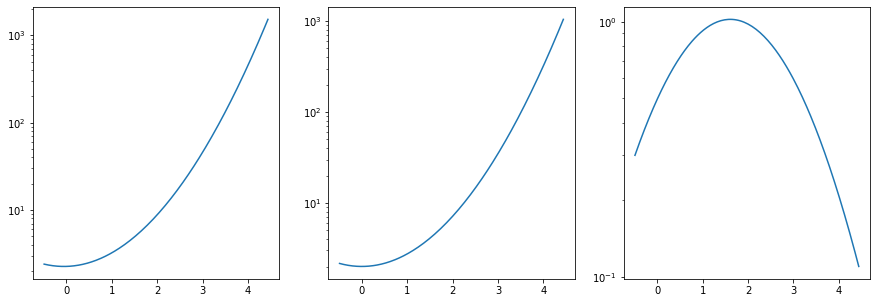

In [13]:
# Is clip by value causing a problem?
yhat_fixed = (yhat_grid - model.y_mean)/model.y_std
a, b, s = model.layer_noise_model.compute_params(yhat_fixed)

fig, axs = plt.subplots(1,3,figsize=[15,5])

axs[0].semilogy(yhat_fixed, a)
axs[1].semilogy(yhat_fixed, b)
axs[2].semilogy(yhat_fixed, s)